In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
import sys
from scipy.spatial.distance import pdist, squareform

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
processed_dir = TOP +'data/processed/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'


In [3]:
df = pd.read_excel(interim_dir+'categorisatons_wscreening_constraints_final_picks_080823.xlsx', sheet_name = 'All data', index_col = [0])

In [4]:
df.shape

(14247, 133)

In [5]:
#df['NCC'].value_counts(dropna = False).plot.bar(figsize = (15,12))

In [6]:
df.columns.tolist()[130:]

['MaxMin_selection_picks', 'category_size', 'final_picks']

In [7]:
df.group_str.nunique()

180

<AxesSubplot:>

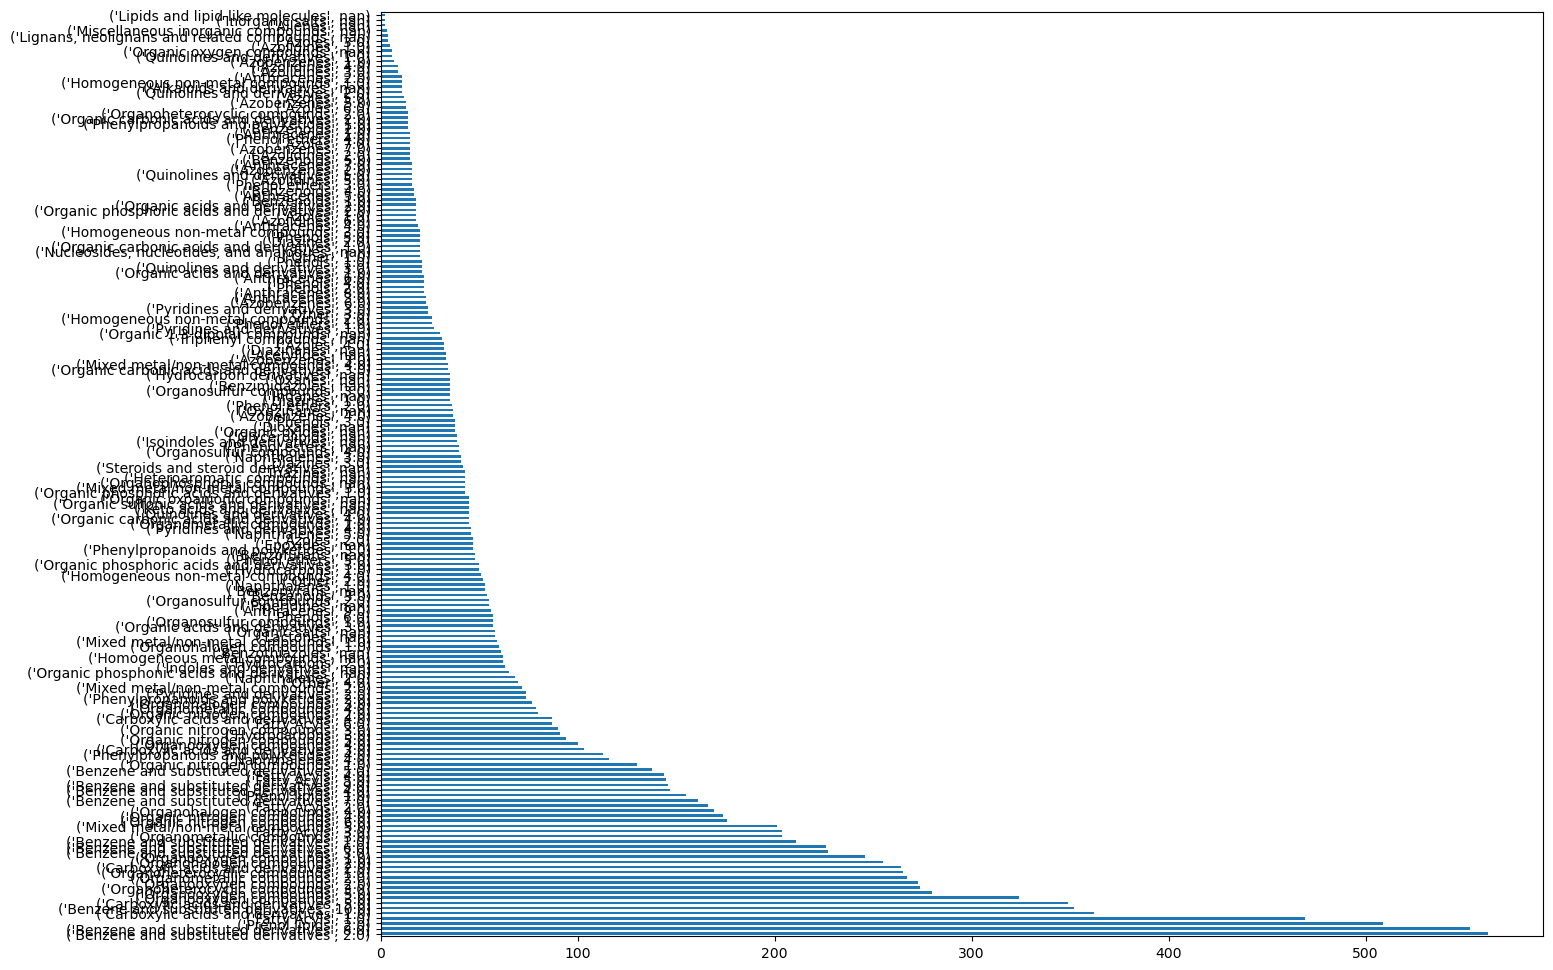

In [8]:
df.group_str.value_counts().plot.barh(figsize = (15,12))

In [9]:
df['final_picks'].value_counts()

1.0    318
Name: final_picks, dtype: int64

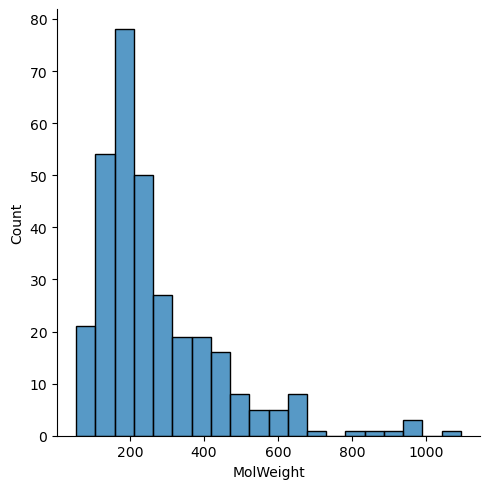

In [10]:
sns.displot(df[df['final_picks']==1]['MolWeight'])


[<BarContainer object of 47 artists>, <BarContainer object of 10 artists>]


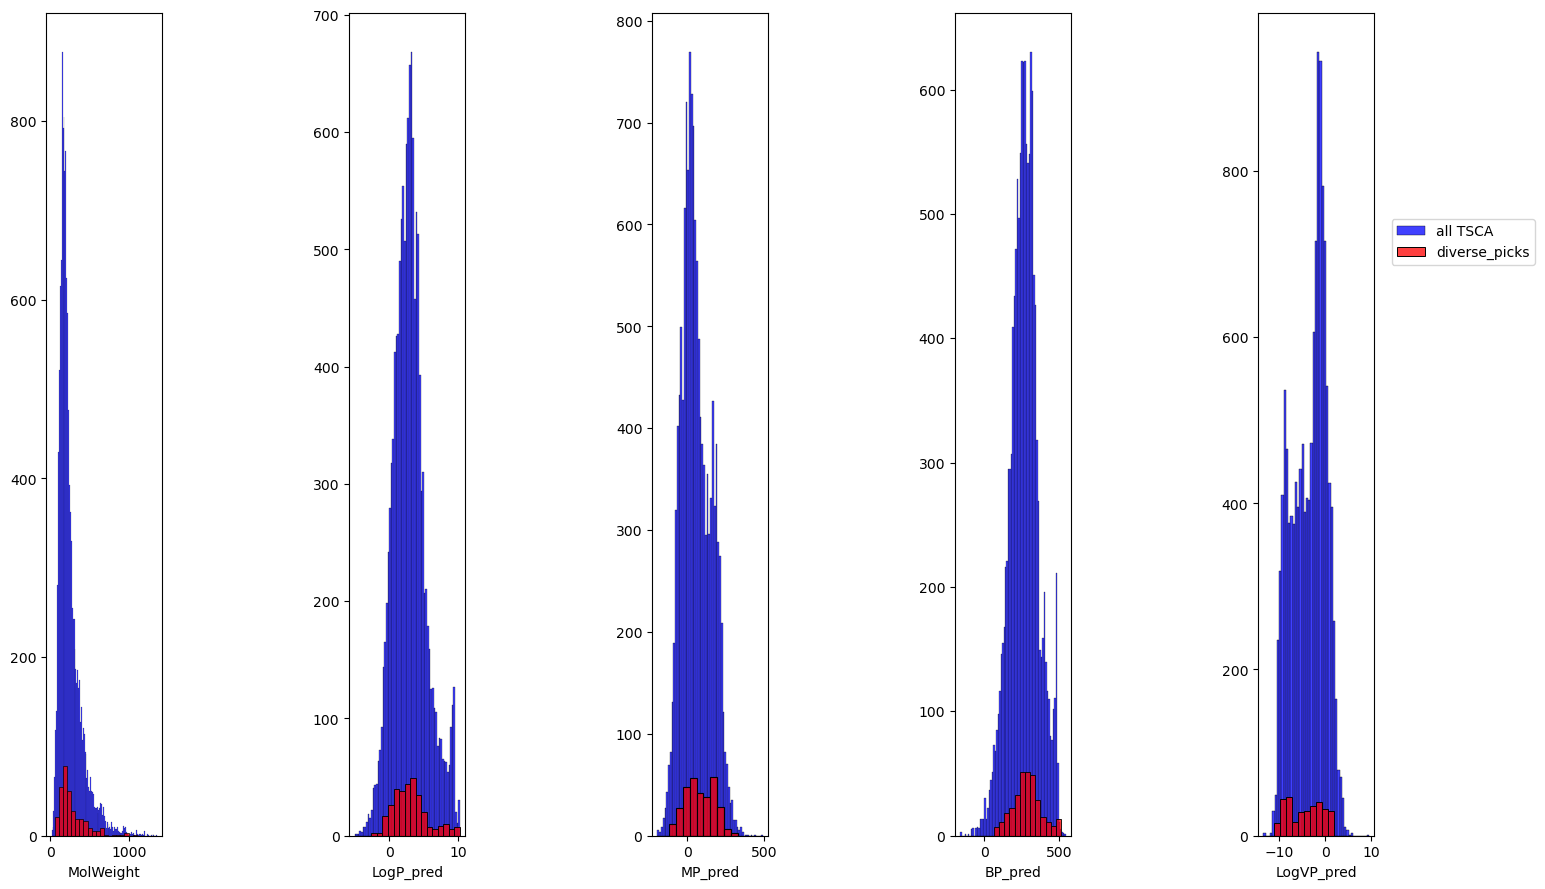

In [11]:
f = plt.figure(figsize = (20,9))
k=0
for n, e in enumerate( ['MolWeight','LogP_pred','MP_pred','BP_pred','LogVP_pred']):
    ax = plt.subplot(1,7, n+1)
    g = sns.histplot(df[e], color = 'b', ax = ax, label = 'all TSCA')
    g = sns.histplot(df[df['final_picks']==1][e], color = 'r', ax = ax, label = 'diverse_picks')
    ax.set_ylabel("")
    #plt.subplots_adjust(hspace = 0.8)
handles, labels = ax.get_legend_handles_labels()
print(handles)
l = plt.legend(handles[0:5], labels[0:5], bbox_to_anchor=(1.15,0.75), loc=2, borderaxespad=0.)
plt.tight_layout()
f.savefig(figures_dir+'Figure1.png', dpi = 300)    

In [12]:
MOLS = dict(zip(df['dtxsid'], df['smiles']))
MOLS = {k:Chem.MolFromSmiles(v) for k,v in MOLS.items()}
MOLS = {i:j for i,j in MOLS.items() if j}
FP0 = pd.DataFrame([np.array(AllChem.GetMorganFingerprintAsBitVect(i,3,1024)) for i in MOLS.values()])
FP0.index = MOLS.keys()
FP0.columns = ['mrgn_%d'%i for i in FP0.columns]

RDKit ERROR: [16:21:13] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [16:21:13] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [16:21:13] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [16:21:13] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [16:21:13] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [16:21:13] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [16:21:13] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [16:21:13] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [16:21:13] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [16:21:13] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [16:21:13] Explicit valence for atom # 0 O, 4, is greater than permitted
RDKit ERROR: [16:21:13] SMILES Parse Error: syntax er

In [13]:
FP0.shape

(14194, 1024)

In [14]:
df1 = df.set_index('dtxsid')

In [15]:
df[['final_picks', 'screenable']]

,final_picks,screenable
0,NaN,1
1,NaN,0
2,NaN,0
3,1.0,1
4,NaN,0
...,...,...
14242,NaN,1
14243,1.0,1
14244,NaN,1
14245,NaN,1


In [16]:
df2 = pd.concat([FP0, df1[['final_picks', 'screenable']]], axis = 1).dropna(subset=['mrgn_0'])

In [17]:
df2['final_picks'] = df2['final_picks'].replace(np.nan, 0)

In [18]:
from sklearn.manifold import TSNE

In [19]:
model = TSNE(learning_rate = 200, random_state = 42)

In [20]:
tsne_features = model.fit_transform(df2.iloc[:, :-2])

In [21]:
tsne_df=pd.concat([pd.DataFrame(tsne_features, index =df2.index, columns = ['tsne_x', 'tsne_y']), df2.iloc[:,-2:]],axis =1)

In [25]:
tsne_df.to_csv(interim_dir+'tsne_df_080823.csv')

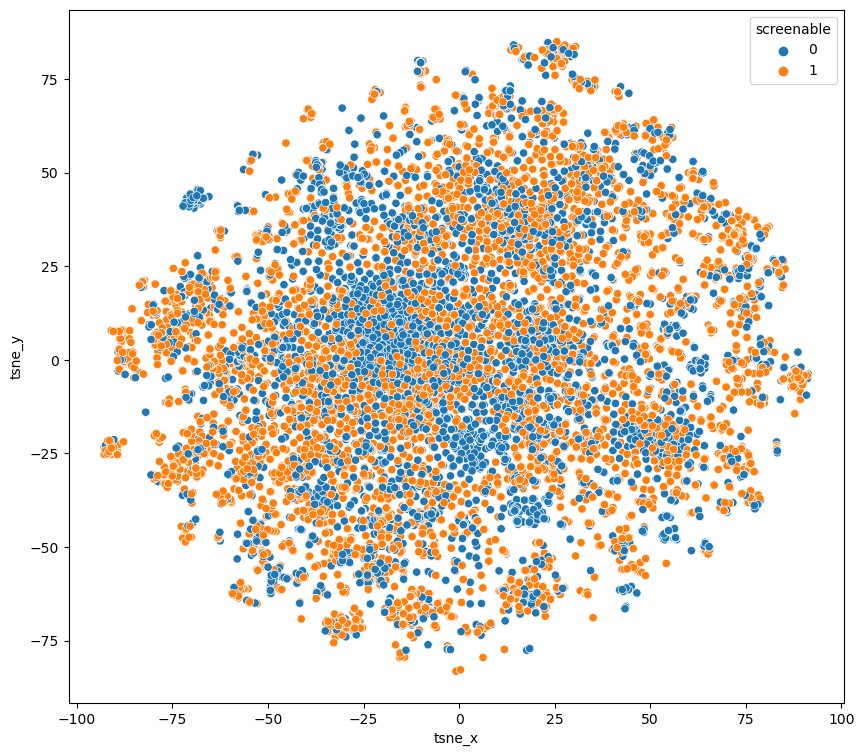

In [22]:
fig, ax = plt.subplots(figsize = (10,9))

ax = sns.scatterplot(x="tsne_x", y="tsne_y",
                     data=tsne_df, hue = 'screenable')
#plt.savefig(figures_dir+'Figure2.png', dpi = 300)

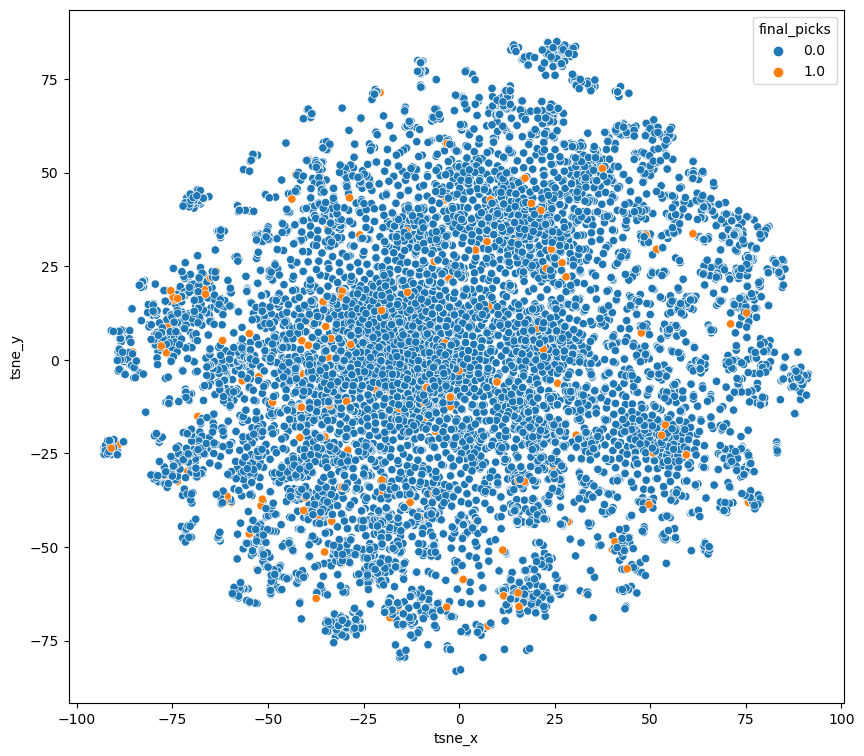

In [26]:
fig, ax = plt.subplots(figsize = (10,9))

ax = sns.scatterplot(x="tsne_x", y="tsne_y",
                     data=tsne_df, hue = 'final_picks')
plt.savefig(figures_dir+'Figure3.png', dpi = 300)#

### DEREK alerts

In [100]:
derek_df = pd.read_csv(external_dir+'TSCA_Inv_DEREK.tsv',sep='\t',low_memory=False)

In [101]:
col_names = derek_df.columns.values
names_w_structure = len([a for a in col_names if "Structure" in a])
names_w_out_structure = [a for a in col_names if "Structure" not in a]
print(f'{names_w_structure} Contain substring "Structure" ')

print(f'{len(names_w_out_structure)} do NOT Contain substring "Structure" ')



0 Contain substring "Structure" 
915 do NOT Contain substring "Structure" 


In [102]:
derek_filtered = derek_df[~derek_df['SMILES'].str.contains('.',na=False,regex=False)].dropna(axis='columns',how='all')

In [103]:
n_rows_removed = derek_df.shape[0] - derek_filtered.shape[0]
n_columns_removed = derek_df.shape[1] - derek_filtered.shape[1]

In [104]:
print(f"{n_rows_removed} rows removed")
print(f"{n_columns_removed} columns removed")

0 rows removed
1 columns removed


In [105]:
a = set(derek_filtered.columns.values)
b = set(names_w_out_structure)
b-a

{'Unnamed: 914'}

In [107]:
derek_filtered.head(1)
derek_filtered_no_ec3 = derek_filtered.filter(regex='^(?!.*EC3)')
 

derek_filtered.to_csv(processed_dir+'derek_filtered.csv')

In [108]:

a = set(derek_filtered.columns.values)
b = set(derek_filtered_no_ec3.columns.values)

a-b

{'Skin sensitisation mammal Alert 1 Derek EC3 Model 2022.1 EC3 Dataset Certified',
 'Skin sensitisation mammal Alert 1 Derek EC3 Model 2022.1 EC3 Similar Compounds',
 'Skin sensitisation mammal Alert 1 Derek EC3 Model 2022.1 LLNA EC3 %',
 'Skin sensitisation mammal Alert 2 Derek EC3 Model 2022.1 EC3 Dataset Certified',
 'Skin sensitisation mammal Alert 2 Derek EC3 Model 2022.1 EC3 Similar Compounds',
 'Skin sensitisation mammal Alert 2 Derek EC3 Model 2022.1 LLNA EC3 %',
 'Skin sensitisation mammal Alert 3 Derek EC3 Model 2022.1 EC3 Dataset Certified',
 'Skin sensitisation mammal Alert 3 Derek EC3 Model 2022.1 EC3 Similar Compounds',
 'Skin sensitisation mammal Alert 3 Derek EC3 Model 2022.1 LLNA EC3 %',
 'Skin sensitisation mammal Most Potent EC3 Prediction',
 'Skin sensitisation mammal Tautomer 1 Alert 1 Derek EC3 Model 2022.1 EC3 Dataset Certified',
 'Skin sensitisation mammal Tautomer 1 Alert 1 Derek EC3 Model 2022.1 EC3 Similar Compounds',
 'Skin sensitisation mammal Tautomer 1 Al

In [109]:
cols = derek_filtered_no_ec3.columns.tolist()
to_remove = cols[2:28]
derek_alerts_reasoning = derek_filtered_no_ec3.loc[:, ~derek_filtered_no_ec3.columns.isin(to_remove)].copy()


In [110]:
derek_alerts_reasoning = derek_alerts_reasoning.drop_duplicates(subset = 'Compound Name')

In [111]:
derek_temp = derek_alerts_reasoning.filter(regex='Compound Name|Alert \d name|reasoning$')
derek_temp = derek_temp.filter(regex='^(?!.*sensitisation)')
derek_temp = derek_temp.filter(regex='^(?!.*Tautomer)')

derek_temp = derek_temp.set_index('Compound Name')

In [112]:
derek_alert_names = derek_temp.filter(regex='Alert \d name')  #ALERT NAMES

In [113]:
my_names = []
for column in derek_alert_names:
    names = derek_alert_names[column].values
    clean_names = [name for name in names if not pd.isna(name)]
    my_names.append(clean_names)

my_names = sum(my_names,[])
my_names = list(set(my_names))
len(my_names)

406

In [114]:
endpoint_names = [i.split(' Alert')[0] for i in derek_temp.filter(regex='Alert \d').columns.values]
unique_endpoints = list(set(endpoint_names))
conditions_list = []
endpoint_list = []

for endpoint in unique_endpoints:
    derek_endpoint_cols = derek_temp.filter(like=f'{endpoint}').filter(regex='reasoning$|Alert \d')
    derek_reasoning = derek_endpoint_cols.filter(regex='reasoning$')
    derek_alerts = derek_endpoint_cols.filter(regex='Alert \d')
    temp_list = []
    for col in derek_alerts:
        alert = derek_alerts.filter(items=[col])
        temp = pd.concat([alert,derek_reasoning],axis=1)
        temp = temp.dropna(how='any').values.tolist()
        [x.insert(0,endpoint) for x in temp]
        temp = [list(x) for x in set(tuple(x) for x in temp)]  #ignore; Removed duplicates, dupes removed at end
        temp_list.append(pd.DataFrame(temp))
    endpoint_conditions = pd.concat(temp_list,axis=0).drop_duplicates().reset_index(drop=True)
    if len(endpoint_conditions) > 0:
        conditions_list.append(endpoint_conditions)
        endpoint_list.append(derek_endpoint_cols.T)




total_conditions = sum([c.shape[0] for c in conditions_list])
print("Total Conditions:", total_conditions)

Total Conditions: 899


In [115]:
tables = []
for i in range(0,len(endpoint_list)):
    conditions = conditions_list[i]
    endpoint = endpoint_list[i]
    tmp =  pd.concat([conditions,endpoint],axis=1)
    n_conditions = conditions.shape[0]

    for i in range(n_conditions):
        row_condition = tmp.iloc[i,1:3].values.tolist()
        row_vals = tmp.iloc[i,0:3].values.tolist()
        for col in tmp.iloc[:,3:]:
            col_values = tmp[col].values[n_conditions:].tolist()
            cond_row = tmp.iloc[i]
            if all(vals in col_values for vals in row_condition):
                row_vals.append(1)
            else:
                row_vals.append(0)
        tmp.iloc[i] = row_vals
    cond_table = tmp.head(conditions.shape[0])
    tables.append(cond_table)



In [116]:
final_table = pd.concat(tables)

In [117]:
final_table

,0,1,2,DTXSID3060164,DTXSID7060837,DTXSID9025879,DTXSID2026282,DTXSID4052188,DTXSID4025242,DTXSID10862055,...,DTXSID7061805,DTXSID4062519,DTXSID00893636,DTXSID9063956,DTXSID7065546,DTXSID5064209,DTXSID7062873,DTXSID9040342,DTXSID3044889,DTXSID3060667
0,Nephrotoxicity mammal,"1,2-Ethylenediamine",EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nephrotoxicity mammal,Hydrazine,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nephrotoxicity mammal,para-Aminophenol or derivative,PLAUSIBLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Nephrotoxicity mammal,Dithiocarbamate,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Nephrotoxicity mammal,"Pyrazolidine-3,5-dione or pyrazolone derivative",PLAUSIBLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,Blood in urine mammal,Acyclovir-like,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Blood in urine mammal,Diflunisal-like,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Blood in urine mammal,Oxyphenbutazone-like,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Blood in urine mammal,Indomethacin-like,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
final_table.rename(columns = {0: 'endpoint', 1: 'toxicophore', 2: 'confidence'}, inplace = True)

In [131]:
final_table.to_csv(interim_dir+'Derek_processed_150423.csv')

In [132]:
final_table

,endpoint,toxicophore,confidence,DTXSID3060164,DTXSID7060837,DTXSID9025879,DTXSID2026282,DTXSID4052188,DTXSID4025242,DTXSID10862055,...,DTXSID7061805,DTXSID4062519,DTXSID00893636,DTXSID9063956,DTXSID7065546,DTXSID5064209,DTXSID7062873,DTXSID9040342,DTXSID3044889,DTXSID3060667
0,Nephrotoxicity mammal,"1,2-Ethylenediamine",EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nephrotoxicity mammal,Hydrazine,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nephrotoxicity mammal,para-Aminophenol or derivative,PLAUSIBLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Nephrotoxicity mammal,Dithiocarbamate,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Nephrotoxicity mammal,"Pyrazolidine-3,5-dione or pyrazolone derivative",PLAUSIBLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,Blood in urine mammal,Acyclovir-like,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Blood in urine mammal,Diflunisal-like,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Blood in urine mammal,Oxyphenbutazone-like,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Blood in urine mammal,Indomethacin-like,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
ft_copy = final_table.copy()

In [144]:
ft_copy2.iloc[:,8].value_counts()

0    13286
1       13
Name: (Androgen receptor modulation mammal, Quinoline or analogue), dtype: int64

<AxesSubplot:>

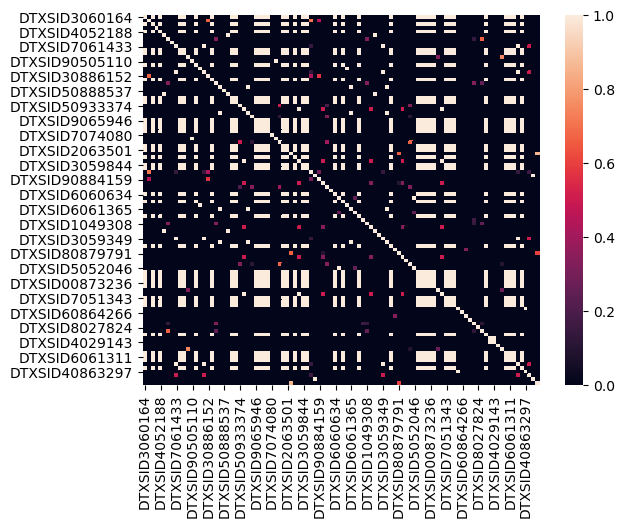

In [147]:
sns.heatmap(S_react.iloc[:100,:100])

<AxesSubplot:>

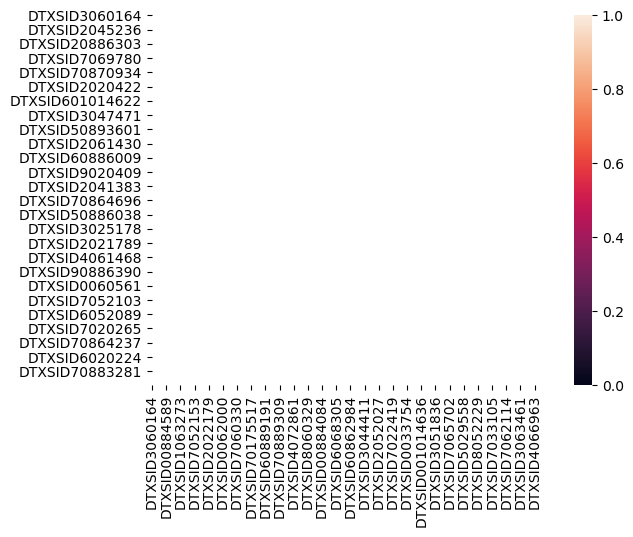

In [148]:
sns.heatmap(S_react)

<AxesSubplot:>

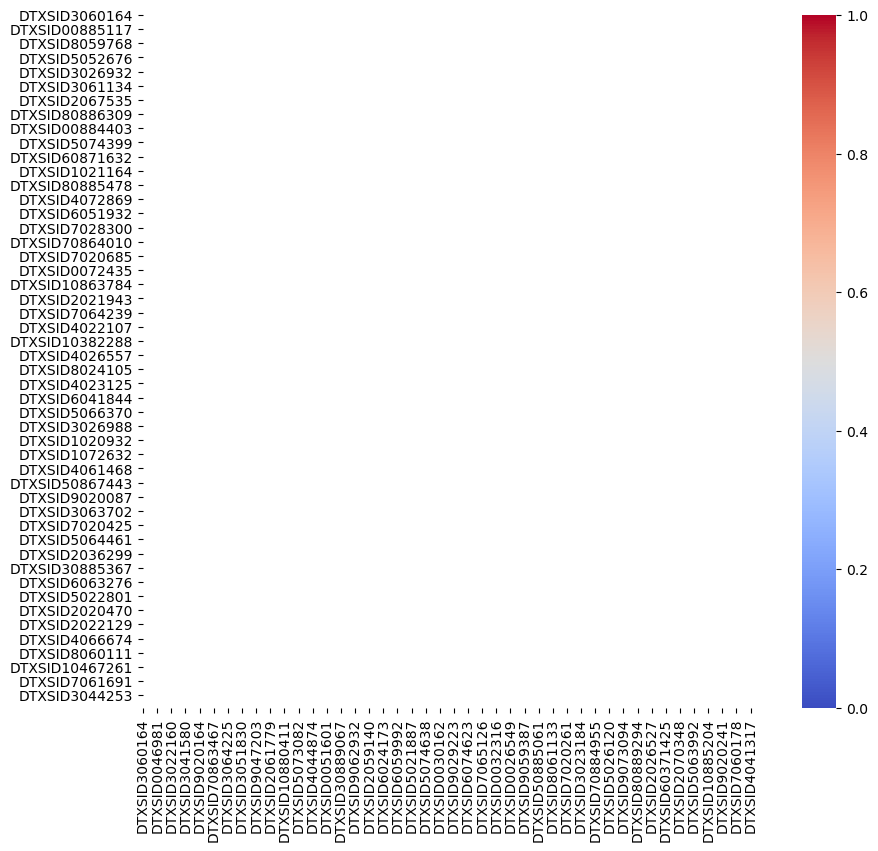

In [134]:
ft_copy = ft_copy.drop(['confidence'], axis = 1)
ft_copy = ft_copy.groupby(['endpoint', 'toxicophore']).agg(lambda x: x.sum())
ft_copy2 = ft_copy.T
# scipy
from scipy.spatial.distance import pdist, squareform
D_react = pd.DataFrame(squareform(pdist(ft_copy2, 'jaccard')), columns = ft_copy2.index, index = ft_copy2.index)
S_react = 1- D_react

plt.figure(figsize = (10,9))
sns.heatmap(S_react, cmap = 'coolwarm')

In [135]:
S_react.to_csv(interim_dir+'Derek_Sim.csv')

In [29]:
final_table = pd.read_csv(interim_dir+'Derek_processed_150423.csv', index_col = [0])

In [33]:
final_table['alert'] = final_table[['endpoint', 'toxicophore']].apply(tuple, axis =1)
final_table['alert'] =[str(e) for e in final_table['alert'] ]

In [46]:
final_table = (final_table.drop(['endpoint', 'toxicophore', 'confidence'], axis = 1)
 .transpose()
)

In [48]:
final_table.columns = final_table.iloc[-1]

In [51]:
final_table = final_table.drop(['alert'], axis = 0)

In [52]:
final_table

alert,"('Nephrotoxicity mammal', '1,2-Ethylenediamine')","('Nephrotoxicity mammal', 'Hydrazine')","('Nephrotoxicity mammal', 'para-Aminophenol or derivative')","('Nephrotoxicity mammal', 'Dithiocarbamate')","('Nephrotoxicity mammal', 'Pyrazolidine-3,5-dione or pyrazolone derivative')","('Nephrotoxicity mammal', 'Organosilicon compound')","('Nephrotoxicity mammal', 'Thiophene')","('Nephrotoxicity mammal', 'Primary aromatic sulphonamide')","('Nephrotoxicity mammal', 'Salicylic acid or analogue')","('Nephrotoxicity mammal', 'Aryl or fulvenyl acetic or 2-propionic acid derivative')",...,"('Uncoupler of oxidative phosphorylation mammal', 'Polynitrophenol or precursor')","('alpha-2-mu-Globulin nephropathy mammal', 'Polyhalogenated benzene')","('alpha-2-mu-Globulin nephropathy mammal', 'Isopentyl group')","('alpha-2-mu-Globulin nephropathy mammal', 'Polychlorinated ethane')","('Blood in urine mammal', 'Cidofovir-like')","('Blood in urine mammal', 'Acyclovir-like')","('Blood in urine mammal', 'Diflunisal-like')","('Blood in urine mammal', 'Oxyphenbutazone-like')","('Blood in urine mammal', 'Indomethacin-like')","('Blood in urine mammal', 'Suprofen-like')"
DTXSID3060164,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID7060837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID9025879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID2026282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID4052188,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID5064209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID7062873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID9040342,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID3044889,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
mydict = {k:v for k,v in zip(df['dtxsid'],df[ 'group_str'])}

In [85]:
selections = {k:v for k,v in zip(df['dtxsid'],df[ 'final_picks']) }

In [77]:
derek = (final_table.reset_index()
 .assign(group_str = final_table.reset_index()['index'].replace(mydict ))
 )

In [87]:
derek = (derek.assign(final_picks = derek['index'].replace(selections)))

In [90]:
derek1 = derek.set_index('index')

In [174]:
derek1.to_csv(interim_dir+'derek1_080823.csv')

In [103]:
from sklearn.manifold import TSNE

alert,"('Nephrotoxicity mammal', '1,2-Ethylenediamine')","('Nephrotoxicity mammal', 'Hydrazine')","('Nephrotoxicity mammal', 'para-Aminophenol or derivative')","('Nephrotoxicity mammal', 'Dithiocarbamate')","('Nephrotoxicity mammal', 'Pyrazolidine-3,5-dione or pyrazolone derivative')","('Nephrotoxicity mammal', 'Organosilicon compound')","('Nephrotoxicity mammal', 'Thiophene')","('Nephrotoxicity mammal', 'Primary aromatic sulphonamide')","('Nephrotoxicity mammal', 'Salicylic acid or analogue')","('Nephrotoxicity mammal', 'Aryl or fulvenyl acetic or 2-propionic acid derivative')",...,"('alpha-2-mu-Globulin nephropathy mammal', 'Isopentyl group')","('alpha-2-mu-Globulin nephropathy mammal', 'Polychlorinated ethane')","('Blood in urine mammal', 'Cidofovir-like')","('Blood in urine mammal', 'Acyclovir-like')","('Blood in urine mammal', 'Diflunisal-like')","('Blood in urine mammal', 'Oxyphenbutazone-like')","('Blood in urine mammal', 'Indomethacin-like')","('Blood in urine mammal', 'Suprofen-like')",group_str,final_picks
index,,,,,,,,,,,,,,,,,,,,,
DTXSID3060164,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"('Triphenyl compounds', nan)",NaN
DTXSID7060837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"('Organohalogen compounds', 1.0)",NaN
DTXSID9025879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"('Phenylpropanoids and polyketides', 2.0)",NaN
DTXSID2026282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"('Anthracenes', 2.0)",NaN
DTXSID4052188,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"('Organooxygen compounds', 3.0)",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID5064209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"('Benzothiazoles', nan)",NaN
DTXSID7062873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"('Fatty Acyls', 2.0)",NaN
DTXSID9040342,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"('Organic carbonic acids and derivatives', 2.0)",NaN


In [104]:
model = TSNE(learning_rate = 200, random_state = 42)

In [105]:
tsne_features = model.fit_transform(derek1.iloc[:, :-2])

In [109]:
tsne_df=pd.concat([pd.DataFrame(tsne_features, index =derek1.index, columns = ['tsne_x', 'tsne_y']), derek1.iloc[:,-2:]],axis =1)

In [112]:
tsne_df['final_picks'] = tsne_df['final_picks'].replace(np.nan, 0)

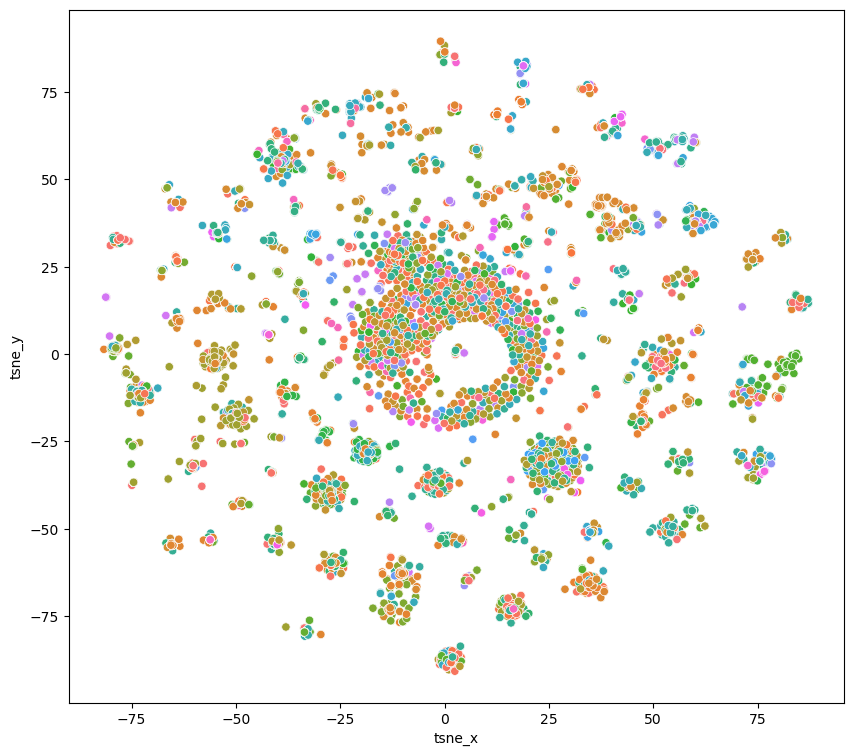

In [115]:
fig, ax = plt.subplots(figsize = (10,9))

ax = sns.scatterplot(x="tsne_x", y="tsne_y",
                     data=tsne_df, hue = 'group_str')
ax.get_legend().set_visible(False)

In [122]:
results = {}
for i, group in derek1.groupby('group_str'):
    results[i] = group

In [125]:
#results["('Acetylides', nan)"]

In [97]:
import sys

In [98]:
LIB = TOP+'src/models/'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

In [99]:
from model_functions import *

In [132]:
dists = {}
for k, v in results.items():
    dists[k] = distance_matrix(v.iloc[:,:-2])

In [126]:
def tsne_plots(a, label = None):
    summary = {}
    summary['label'] = label
    model = TSNE(learning_rate = 200, random_state = 42)
    tsne_features = model.fit_transform(a[label].iloc[:,:-2])
    tsne_features = pd.DataFrame(tsne_features, index = a[label].index, columns = ['tsne_x', 'tsne_y'])
    tsne_df = pd.concat([tsne_features, a[label].iloc[:,-1:]], axis = 1)
    summary['tsne'] = tsne_df
    return summary

In [127]:
tsne_lst = []
for k,v in results.items():
    if v.shape[0] > 1:
        tsne_lst.append(tsne_plots(results, label = k))


In [167]:
for i in range(len(tsne_lst)):
    if tsne_lst[i]['tsne']['final_picks'].sum() >= 3:
        print(i, tsne_lst[i]['label'])
       

0 ('Acetylides', nan)
5 ('Anthracenes', 3.0)
8 ('Anthracenes', 6.0)
10 ('Anthracenes', 8.0)
11 ('Anthracenes', 9.0)
14 ('Azobenzenes', 3.0)
15 ('Azobenzenes', 4.0)
17 ('Azobenzenes', 6.0)
20 ('Azoles', 2.0)
22 ('Azoles', 4.0)
32 ('Benzene and substituted derivatives', 1.0)
35 ('Benzene and substituted derivatives', 3.0)
36 ('Benzene and substituted derivatives', 4.0)
37 ('Benzene and substituted derivatives', 5.0)
38 ('Benzene and substituted derivatives', 6.0)
39 ('Benzene and substituted derivatives', 7.0)
41 ('Benzene and substituted derivatives', 9.0)
44 ('Benzenoids', 3.0)
47 ('Benzimidazoles', nan)
48 ('Benzofurans', nan)
49 ('Benzopyrans', nan)
50 ('Benzothiazoles', nan)
52 ('Carboxylic acids and derivatives', 2.0)
53 ('Carboxylic acids and derivatives', 3.0)
54 ('Carboxylic acids and derivatives', 4.0)
56 ('Diazinanes', nan)
57 ('Diazines', 1.0)
59 ('Diazines', 3.0)
60 ('Dioxanes', nan)
61 ('Epoxides', nan)
63 ('Fatty Acyls', 2.0)
64 ('Fatty Acyls', 3.0)
65 ('Fatty Acyls', 4.0)

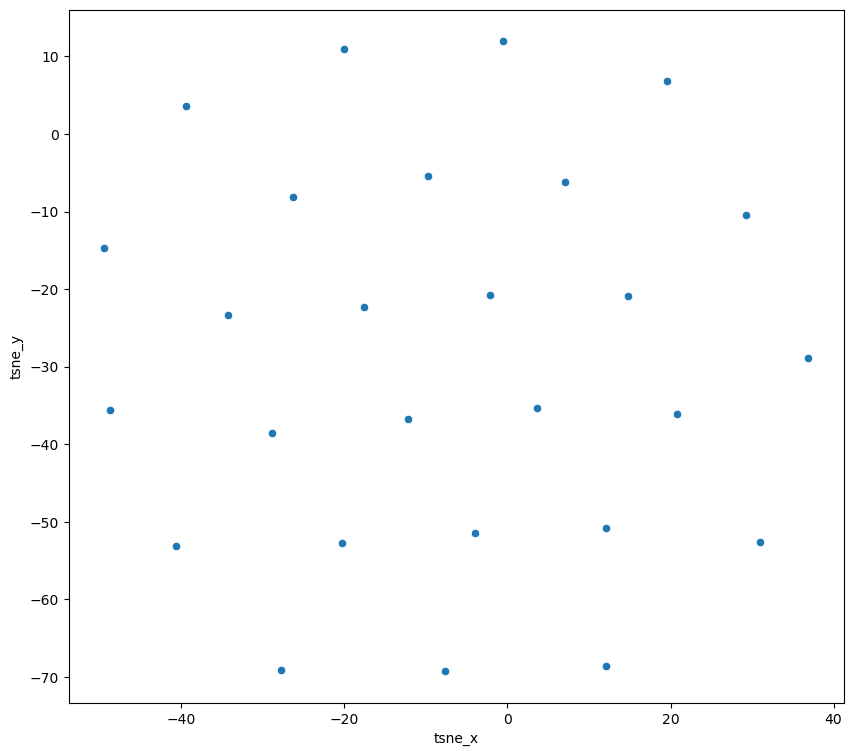

In [170]:
fig, ax = plt.subplots(figsize = (10,9))

#colors = {1:'red', 0 : 'blue'}

#grouped = tsne_df.groupby('Source')
#for key, group in grouped:
#    group.plot(ax=ax, kind='scatter', x='tsne_x', y='tsne_y', alpha = alphas[0], label=key, color=colors[key])
#ax = sns.kdeplot(x="tsne_x", y="tsne_y", fill = True,
#                    data=tsne_lst[159]['tsne'])
#hue = 'final_picks',
ax = sns.scatterplot(x="tsne_x", y="tsne_y", 
                     data=tsne_lst[159]['tsne'])

<AxesSubplot:xlabel='index', ylabel='index'>

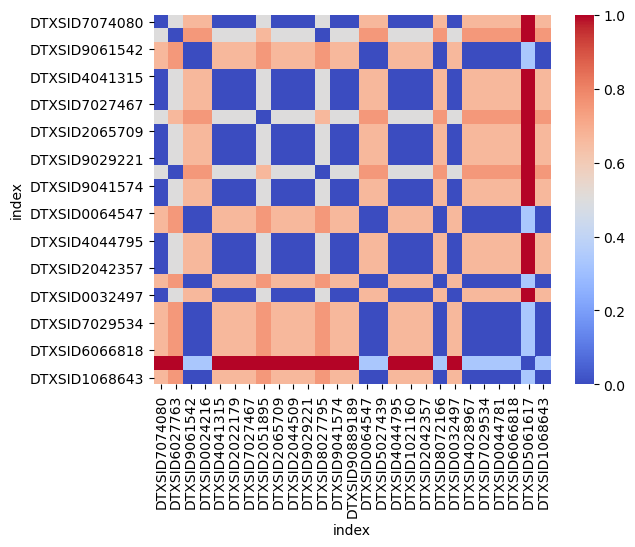

In [171]:
sns.heatmap(dists["('Pyridines and derivatives', 1.0)"], cmap = 'coolwarm')

In [172]:
dists["('Pyridines and derivatives', 1.0)"]

index,DTXSID7074080,DTXSID6027763,DTXSID9061542,DTXSID0024216,DTXSID4041315,DTXSID2022179,DTXSID7027467,DTXSID2051895,DTXSID2065709,DTXSID2044509,...,DTXSID1021160,DTXSID2042357,DTXSID8072166,DTXSID0032497,DTXSID4028967,DTXSID7029534,DTXSID0044781,DTXSID6066818,DTXSID5061617,DTXSID1068643
index,,,,,,,,,,,,,,,,,,,,,
DTXSID7074080,0.000000,0.500000,0.666667,0.666667,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,...,0.000000,0.000000,0.666667,0.000000,0.666667,0.666667,0.666667,0.666667,1.000000,0.666667
DTXSID6027763,0.500000,0.000000,0.750000,0.750000,0.500000,0.500000,0.500000,0.666667,0.500000,0.500000,...,0.500000,0.500000,0.750000,0.500000,0.750000,0.750000,0.750000,0.750000,1.000000,0.750000
DTXSID9061542,0.666667,0.750000,0.000000,0.000000,0.666667,0.666667,0.666667,0.750000,0.666667,0.666667,...,0.666667,0.666667,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000
DTXSID0024216,0.666667,0.750000,0.000000,0.000000,0.666667,0.666667,0.666667,0.750000,0.666667,0.666667,...,0.666667,0.666667,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000
DTXSID4041315,0.000000,0.500000,0.666667,0.666667,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,...,0.000000,0.000000,0.666667,0.000000,0.666667,0.666667,0.666667,0.666667,1.000000,0.666667
DTXSID2022179,0.000000,0.500000,0.666667,0.666667,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,...,0.000000,0.000000,0.666667,0.000000,0.666667,0.666667,0.666667,0.666667,1.000000,0.666667
DTXSID7027467,0.000000,0.500000,0.666667,0.666667,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,...,0.000000,0.000000,0.666667,0.000000,0.666667,0.666667,0.666667,0.666667,1.000000,0.666667
DTXSID2051895,0.500000,0.666667,0.750000,0.750000,0.500000,0.500000,0.500000,0.000000,0.500000,0.500000,...,0.500000,0.500000,0.750000,0.500000,0.750000,0.750000,0.750000,0.750000,1.000000,0.750000
DTXSID2065709,0.000000,0.500000,0.666667,0.666667,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,...,0.000000,0.000000,0.666667,0.000000,0.666667,0.666667,0.666667,0.666667,1.000000,0.666667


In [173]:
import pickle
pickle.dump( dists, open(interim_dir+ "dists_derek_080823.pkl", "wb" ) )